## Lab 2

This material is extracted from the book "Artificial Intelligence: Foundations of Computational Agents". Copyright 2017-2024 David L. Poole and Alan K. Mackworth

In the following implementation, both agents and the environment are treated as
objects in the send of object-oriented programs: they can have an internal state
they maintain, and can evaluate methods that can provide answers.

In [ ]:
class Displayable(object):
    """Class that uses 'display'.
    The amount of detail is controlled by max_display_level
    """
    max_display_level = 1   # can be overridden in subclasses or instances

    def display(self,level,*args,**nargs):
        """print the arguments if level is less than or equal to the
        current max_display_level.
        level is an integer.
        the other arguments are whatever arguments print can take.
        """
        if level <= self.max_display_level:
            print(*args, **nargs)  ##if error you are using Python2 not Python3


An agent takes the precept, updates its internal state, and output it next
action.

An environment takes in actions of the agents, updates its internal state
and returns the next percept, using the method do.

In [ ]:
class Agent(Displayable):

    def initial_action(self, percept):
        """return the initial action."""
        return self.select_action(percept)   # same as select_action

    def select_action(self, percept):
        """return the next action (and update internal state) given percept
        percept is variable:value dictionary
        """
        raise NotImplementedError("go")   # abstract method

class Environment(Displayable):
    def initial_percept(self):
        """returns the initial percept for the agent"""
        raise NotImplementedError("initial_percept")   # abstract method

    def do(self, action):
        """does the action in the environment
        returns the next percept """
        raise NotImplementedError("Environment.do")   # abstract method

class Simulate(Displayable):
    """simulate the interaction between the agent and the environment
    for n time steps.
    Returns a pair of the agent state and the environment state.
    """
    def __init__(self,agent, environment):
        self.agent = agent
        self.env = environment
        self.percept = self.env.initial_percept()
        self.percept_history = [self.percept]
        self.action_history = []

    def go(self, n):
        for i in range(n):
            action = self.agent.select_action(self.percept)
            self.display(2,f"i={i} action={action}")
            self.percept = self.env.do(action)
            self.display(2,f"      percept={self.percept}")

## Example Buying agents

The environment state is given in terms of the time and the amount of paper in
stock. It also remembers the in-stock history and the price history. The percept
consists of the price and the amount of paper in stock. The action of the agent
is the number to buy. The agent cannot access the price model; it just observes the prices and the amount in stock. The agent has to decide how much to buy.
The belief state of the agent is an estimate of the average price of the paper,
and the total amount of money the agent has spent.

In [ ]:
def select_from_dist(item_prob_dist):
    """ returns a value from a distribution.
    item_prob_dist is an item:probability dictionary, where the
        probabilities sum to 1.
    returns an item chosen in proportion to its probability
    """
    ranreal = random.random()
    for (it,prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError(f"{item_prob_dist} is not a probability distribution")

agent spent $739.92


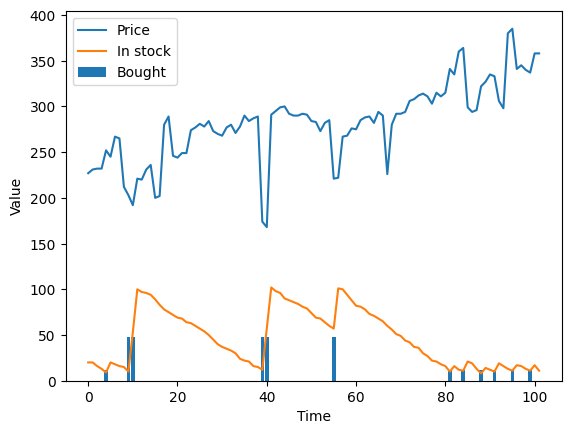

In [ ]:
import random
class TP_env(Environment):
    price_delta = [0, 0, 0, 21, 0, 20, 0, -64, 0, 0, 23, 0, 0, 0, -35,
        0, 76, 0, -41, 0, 0, 0, 21, 0, 5, 0, 5, 0, 0, 0, 5, 0, -15, 0, 5,
       0, 5, 0, -115, 0, 115, 0, 5, 0, -15, 0, 5, 0, 5, 0, 0, 0, 5, 0,
       -59, 0, 44, 0, 5, 0, 5, 0, 0, 0, 5, 0, -65, 50, 0, 5, 0, 5, 0, 0,
       0, 5, 0]
    sd = 5  # noise standard deviation

    def __init__(self):
        """paper buying agent"""
        self.time=0
        self.stock=20
        self.stock_history = []  # memory of the stock history
        self.price_history = []  # memory of the price history

    def initial_percept(self):
        """return initial percept"""
        self.stock_history.append(self.stock)
        self.price = round(234+self.sd*random.gauss(0,1))
        self.price_history.append(self.price)
        return {'price': self.price,
                'instock': self.stock}

    def do(self, action):
        """does action (buy) and returns percept consisting of price and instock"""
        used = select_from_dist({6:0.1, 5:0.1, 4:0.1, 3:0.3, 2:0.2, 1:0.2})
        # used = select_from_dist({7:0.1, 6:0.2, 5:0.2, 4:0.3, 3:0.1, 2:0.1}) # uses more paper
        bought = action['buy']
        self.stock = self.stock+bought-used
        self.stock_history.append(self.stock)
        self.time += 1
        self.price =  round(self.price
                        + self.price_delta[self.time%len(self.price_delta)] # repeating pattern
                        + self.sd*random.gauss(0,1)) # plus randomness
        self.price_history.append(self.price)
        return {'price': self.price,
                'instock': self.stock}

class TP_agent(Agent):
    def __init__(self):
        self.spent = 0
        percept = env.initial_percept()
        self.ave = self.last_price = percept['price']
        self.instock = percept['instock']
        self.buy_history = []

    def select_action(self, percept):
        """return next action to carry out
        """
        self.last_price = percept['price']
        self.ave = self.ave+(self.last_price-self.ave)*0.05
        self.instock = percept['instock']
        if self.last_price < 0.9*self.ave and self.instock < 60:
            tobuy = 48
        elif self.instock < 12:
            tobuy = 12
        else:
            tobuy = 0
        self.spent += tobuy*self.last_price
        self.buy_history.append(tobuy)
        return {'buy': tobuy}

env = TP_env()
ag = TP_agent()
sim = Simulate(ag,env)
#sim.go(90)
#ag.spent/env.time   ## average spent per time period

import matplotlib.pyplot as plt

class Plot_history(object):
    """Set up the plot for history of price and number in stock"""
    def __init__(self, ag, env):
        self.ag = ag
        self.env = env
        plt.ion()
        plt.xlabel("Time")
        plt.ylabel("Value")


    def plot_env_hist(self):
        """plot history of price and instock"""
        num = len(env.stock_history)
        plt.plot(range(num),env.price_history,label="Price")
        plt.plot(range(num),env.stock_history,label="In stock")
        plt.legend()
        #plt.draw()

    def plot_agent_hist(self):
        """plot history of buying"""
        num = len(ag.buy_history)
        plt.bar(range(1,num+1), ag.buy_history, label="Bought")
        plt.legend()

sim.go(100); print(f"agent spent ${ag.spent/100}")
pl = Plot_history(ag,env); pl.plot_env_hist(); pl.plot_agent_hist()

## Hierarchical Controller


In this implementation, each layer, including the top layer, implements the environmen class, because each layer is seen as an environment from the layer
above.

The environment just defines the walls, and the body includes everything to do with the agent.

Note that the named locations are part of the (top-level of the) agent,
not part of the environment, although they could have been.

In [ ]:
class Rob_env(Environment):
    def __init__(self,walls = {}):
        """walls is a set of line segments
               where each line segment is of the form ((x0,y0),(x1,y1))
        """
        self.walls = walls # The environment defines the walls.

import math
import matplotlib.pyplot as plt
import time

class Rob_body(Environment):   # The body defines everything about the agent body.
    def __init__(self, env, init_pos=(0,0,90)):
        """ env is the current environment
        init_pos is a triple of (x-position, y-position, direction)
            direction is in degrees; 0 is to right, 90 is straight-up, etc
        """
        self.env = env
        self.rob_x, self.rob_y, self.rob_dir = init_pos
        self.turning_angle = 18   # degrees that a left makes
        self.whisker_length = 6   # length of the whisker
        self.whisker_angle = 30   # angle of whisker relative to robot
        self.crashed = False
        # The following control how it is plotted
        self.plotting = False      # whether the trace is being plotted
        self.sleep_time = 0.05     # time between actions (for real-time plotting)
        # The following are data structures maintained:
        self.history = [(self.rob_x, self.rob_y)] # history of (x,y) positions
        self.wall_history = []     # history of hitting the wall

    def percept(self):
        return {'rob_x_pos':self.rob_x, 'rob_y_pos':self.rob_y,
                'rob_dir':self.rob_dir, 'whisker':self.whisker(), 'crashed':self.crashed}
    initial_percept = percept  # use percept function for initial percept too

    def do(self,action):
        """ action is {'steer':direction}
        direction is 'left', 'right' or 'straight'
        """
        if self.crashed:
            return self.percept()
        direction = action['steer']
        compass_deriv = {'left':1,'straight':0,'right':-1}[direction]*self.turning_angle
        self.rob_dir = (self.rob_dir + compass_deriv +360)%360  # make in range [0,360)
        rob_x_new = self.rob_x + math.cos(self.rob_dir*math.pi/180)
        rob_y_new = self.rob_y + math.sin(self.rob_dir*math.pi/180)
        path = ((self.rob_x,self.rob_y),(rob_x_new,rob_y_new))
        if any(line_segments_intersect(path,wall) for wall in self.env.walls):
            self.crashed = True
            if self.plotting:
                plt.plot([self.rob_x],[self.rob_y],"r*",markersize=20.0)
                plt.draw()
        self.rob_x, self.rob_y = rob_x_new, rob_y_new
        self.history.append((self.rob_x, self.rob_y))
        if self.plotting and not self.crashed:
            plt.plot([self.rob_x],[self.rob_y],"go")
            plt.draw()
            plt.pause(self.sleep_time)
        return self.percept()

    def whisker(self):
        """returns true whenever the whisker sensor intersects with a wall
        """
        whisk_ang_world = (self.rob_dir-self.whisker_angle)*math.pi/180
            # angle in radians in world coordinates
        wx = self.rob_x + self.whisker_length * math.cos(whisk_ang_world)
        wy = self.rob_y + self.whisker_length * math.sin(whisk_ang_world)
        whisker_line = ((self.rob_x,self.rob_y),(wx,wy))
        hit = any(line_segments_intersect(whisker_line,wall)
                    for wall in self.env.walls)
        if hit:
            self.wall_history.append((self.rob_x, self.rob_y))
            if self.plotting:
                plt.plot([self.rob_x],[self.rob_y],"ro")
                plt.draw()
        return hit

def line_segments_intersect(linea,lineb):
    """returns true if the line segments, linea and lineb intersect.
    A line segment is represented as a pair of points.
    A point is represented as a (x,y) pair.
    """
    ((x0a,y0a),(x1a,y1a)) = linea
    ((x0b,y0b),(x1b,y1b)) = lineb
    da, db = x1a-x0a, x1b-x0b
    ea, eb = y1a-y0a, y1b-y0b
    denom = db*ea-eb*da
    if denom==0:    # line segments are parallel
        return False
    cb = (da*(y0b-y0a)-ea*(x0b-x0a))/denom  # position along line b
    if cb<0 or cb>1:
        return False
    ca = (db*(y0b-y0a)-eb*(x0b-x0a))/denom # position along line a
    return 0<=ca<=1

The middle layer acts like both a controller (for the environment layer) and an
environment for the upper layer. It has to tell the environment how to steer.
Thus it calls *env.do(·)*. It also is told the position to go to and the timeout. Thus it also has to implement *do(·)*.

In [ ]:
class Rob_middle_layer(Environment):
    def __init__(self,env):
        self.env=env
        self.percept = env.initial_percept()
        self.straight_angle = 11 # angle that is close enough to straight ahead
        self.close_threshold = 2  # distance that is close enough to arrived
        self.close_threshold_squared = self.close_threshold**2 # just compute it once

    def initial_percept(self):
        return {}

    def do(self, action):
        """action is {'go_to':target_pos,'timeout':timeout}
        target_pos is (x,y) pair
        timeout is the number of steps to try
        returns {'arrived':True} when arrived is true
             or {'arrived':False} if it reached the timeout
        """
        if 'timeout' in action:
            remaining = action['timeout']
        else:
            remaining = -1    # will never reach 0
        target_pos = action['go_to']
        arrived = self.close_enough(target_pos)
        while not arrived and remaining != 0:
            self.percept = self.env.do({"steer":self.steer(target_pos)})
            remaining -= 1
            arrived = self.close_enough(target_pos)
        return {'arrived':arrived}


    # The following method determines how to steer depending on whether the goal is to the right or the left of where the robot is facing.

    def steer(self,target_pos):
        if self.percept['whisker']:
            self.display(3,'whisker on', self.percept)
            return "left"
        else:
            return self.head_towards(target_pos)

    def head_towards(self,target_pos):
            """ given a target position, return the action that heads towards that position
            """
            gx,gy = target_pos
            rx,ry = self.percept['rob_x_pos'],self.percept['rob_y_pos']
            goal_dir = math.acos((gx-rx)/math.sqrt((gx-rx)*(gx-rx)
                                                   +(gy-ry)*(gy-ry)))*180/math.pi
            if ry>gy:
                goal_dir = -goal_dir
            goal_from_rob = (goal_dir - self.percept['rob_dir']+540)%360-180
            assert -180 < goal_from_rob <= 180
            if goal_from_rob > self.straight_angle:
                return "left"
            elif goal_from_rob < -self.straight_angle:
                return "right"
            else:
                return "straight"

    def close_enough(self,target_pos):
        gx,gy = target_pos
        rx,ry = self.percept['rob_x_pos'],self.percept['rob_y_pos']
        return (gx-rx)**2 + (gy-ry)**2 <= self.close_threshold_squared

The top layer treats the middle layer as its environment. Note that the top layer tells it the locations to visit.

In [ ]:
class Rob_top_layer(Environment):
    def __init__(self, middle, timeout=200, locations = {'mail':(-5,10),
                          'o103':(50,10), 'o109':(100,10),'storage':(101,51)} ):
        """middle is the middle layer
        timeout is the number of steps the middle layer goes before giving up
        locations is a loc:pos dictionary
            where loc is a named location, and pos is an (x,y) position.
        """
        self.middle = middle
        self.timeout = timeout  # number of steps before the middle layer should give up
        self.locations = locations

    def do(self,plan):
        """carry out actions.
        actions is of the form {'visit':list_of_locations}
        It visits the locations in turn.
        """
        to_do = plan['visit']
        for loc in to_do:
            position = self.locations[loc]
            arrived = self.middle.do({'go_to':position, 'timeout':self.timeout})
            self.display(1,"Arrived at",loc,arrived)



The following is used to plot the locations, the walls and (eventually) the movement of the robot. It can either plot the movement if the robot as it is going (with the default *env.plotting = True*), or not plot it as it is going (*setting env.plotting = False*; in this case the trace can be plotted using *pl.plot run()*).

Arrived at o109 {'arrived': True}
Arrived at storage {'arrived': True}
Arrived at o109 {'arrived': True}
Arrived at o103 {'arrived': True}


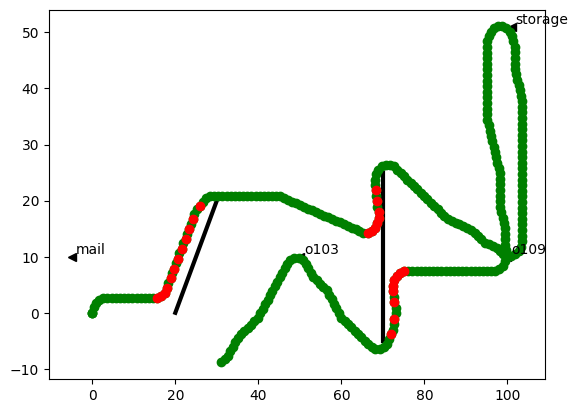

In [ ]:
import matplotlib.pyplot as plt

class Plot_env(Displayable):
    def __init__(self, body,top):
        """sets up the plot
        """
        self.body = body
        self.top = top
        plt.ion()
        plt.axes().set_aspect('equal')
        self.redraw()

    def redraw(self):
        plt.clf()
        for wall in body.env.walls:
            ((x0,y0),(x1,y1)) = wall
            plt.plot([x0,x1],[y0,y1],"-k",linewidth=3)
        for loc in top.locations:
            (x,y) = top.locations[loc]
            plt.plot([x],[y],"k<")
            plt.text(x+1.0,y+0.5,loc) # print the label above and to the right
        plt.plot([body.rob_x],[body.rob_y],"go")
        plt.gca().figure.canvas.draw()
        if self.body.history or self.body.wall_history:
            self.plot_run()

    def plot_run(self):
        """plots the history after the agent has finished.
        This is typically only used if body.plotting==False
        """
        if self.body.history:
            xs,ys = zip(*self.body.history)
            plt.plot(xs,ys,"go")
        if self.body.wall_history:
            wxs,wys = zip(*self.body.wall_history)
            plt.plot(wxs,wys,"ro")


env = Rob_env({((20,0),(30,20)), ((70,-5),(70,25))})
body = Rob_body(env)
middle = Rob_middle_layer(body)
top = Rob_top_layer(middle)
pl=Plot_env(body,top)

top.do({'visit':['o109','storage','o109','o103']})
middle.do({'go_to':(30,-10), 'timeout':200})

pl.plot_run() # Comment it and use env.plotting = True for seeing the movements step by step

A trace of the trajectory of the agent. Red dots correspond to the
whisker sensor being on; the green dot to the whisker sensor being off. The agent starts at position (0, 0) facing up.